CNNs: Akbank Derin Öğrenme Bootcamp kapsamında görsel veri seti sınıflandırma problemi.

In [1]:
#Gerekli Kütüphanelerin import edilmesi.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim
import optuna
from tqdm import tqdm

#Uyarıları yoksaymak.
import warnings
warnings.filterwarnings("ignore")

print("Kütüphane yükleme işlemleri başarılı")

#Gpu kullanılabilirlik kontrolü.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Kütüphane yükleme işlemleri başarılı


C:\Users\demir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

Veri Setini Yükleme

In [2]:
def data_loader(batch_size = 32):
    transform = transforms.Compose([
        transforms.Resize((128, 128)), # Görüntüleri aynı boyuta getirir.
        transforms.RandomHorizontalFlip(),   # Yatay çevirme
        transforms.RandomRotation(15),
        transforms.ColorJitter( 
            brightness=0.2, 
            contrast=0.2, 
            saturation=0.2, 
            hue=0.05
        ), # Color Jitter ile parlaklık, kontrast, doygunluk ve renk tonu ayarlamak
        transforms.ToTensor(), # Görüntüyü tensör forma çevirir.
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Pixel değerlerini ve RGB renkleri ölçekler.
    ])
    
    # Orijinal train set (classes için saklıyoruz)
    full_train_set = torchvision.datasets.ImageFolder(root = "data/train", transform= transform)
    
    # Test set
    test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))  # Test seti gerçek dünyayı baz aldığı için veri çoğaltma uygulanmaz.
    
    # Train ve validation olarak bölme
    train_size = int(0.8 * len(full_train_set))
    val_size = len(full_train_set) - train_size
    train_set, val_set = random_split(full_train_set, [train_size, val_size])
    
    # DataLoader'ları oluşturma
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle= True, num_workers= 2, pin_memory= True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle= False, num_workers= 2, pin_memory= True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle= False, num_workers= 2, pin_memory= True)
    
    return train_loader, val_loader, test_loader, full_train_set  # classes için full_train_set döndür

# Kullanımı
train_loader, val_loader, test_loader, full_train_set = data_loader()

# Gerekli bilgileri yazdırır.
print("Veri seti indirme ve bölme işlemi başarılı.")
print("Sınıflar:", full_train_set.classes)
print("Train veri sayısı:", len(train_loader.dataset))
print("Validation veri sayısı:", len(val_loader.dataset))
print("Test veri sayısı:", len(test_loader.dataset))
images, labels = next(iter(train_loader))
print("Sınıf sayısı:", len(full_train_set.classes))

Veri seti indirme ve bölme işlemi başarılı.
Sınıflar: ['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ford', 'GMC', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo']
Train veri sayısı: 9213
Validation veri sayısı: 2304
Test veri sayısı: 2475
Sınıf sayısı: 33


Veri görselleştirme

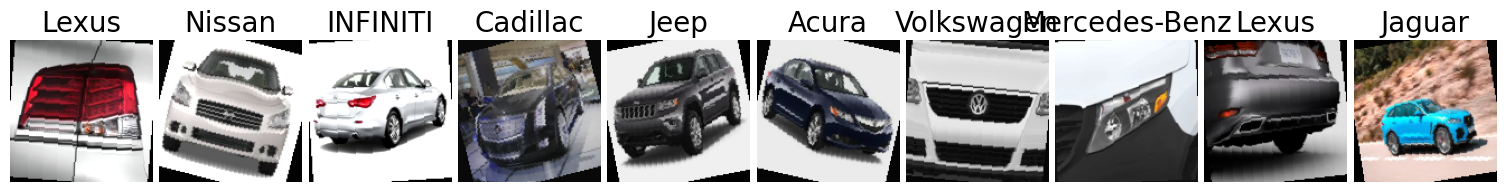

In [3]:
def imshow(img):
    #Verileri Normalize etmeden önce geri dönüştür çünkü renkli veri.
    img = img / 2 + 0.5 # Normalize işlemin tersi.
    np_img = img.numpy() #Tensordan numpy arraya dönüştür.
    plt.imshow(np.transpose(np_img, (1, 2, 0))) #3 kanal için renkleri doğru şekilde gösterme
    plt.axis('off')
    
    
#Örneklem almak
def sample_image(train_loader):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    return images, labels

#GÖrselleştirme
def visualize(n= 10):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    class_names = full_train_set.classes
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        plt.title(class_names[labels[i].item()], fontsize= 20)
        plt.axis('off')
    plt.tight_layout(pad= 0.5)
    plt.show()

visualize(10)

CNNs modelinin Oluşturulması, Eğitilmesi, Performans değerlerine bakılması.

Modelin Oluşturulması.

In [4]:
class CNN(nn.Module):
    def __init__(self, dropout= 0.39267072116539314, num_classes= 33):
        super(CNN, self).__init__()
        self.relu = nn.ReLU() #Relu aktivasyon fonksiyonu.
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) #Adaptiv pooling katmanı.
        self.dropout = nn.Dropout(dropout) #Dropoutu %30 oranında çalıştırır.

        # Conv blokları
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   #İlk convolution katmanı
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  #İkinci convolution katmanı
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) #Üçüncü convolution katmanı 
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected katmanlar
        self.fc1 = nn.Linear(128*4*4, 256) #Giriş boyutu 128*4*4 yapar
        self.fc2 = nn.Linear(256, num_classes) #Çıkış katmanı 

    def forward(self, x): #Görüntü sınıflandırması
        x = self.maxpool(self.relu(self.conv1(x))) #1. blok
        x = self.maxpool(self.relu(self.conv2(x))) #2. blok
        x = self.maxpool(self.relu(self.conv3(x))) #3. blok 
        x = self.adaptive_pool(x) 
        x = x.view(x.size(0), -1) #Flatten
        x = self.dropout(self.relu(self.fc1(x))) #Fully connected layer
        x = self.fc2(x) #Output
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu",)
num_classes = len(full_train_set.classes)
model = CNN(num_classes = num_classes).to(device)
loss_optimizer = lambda model: (
    nn.CrossEntropyLoss(), #Multi class clasiffication problemi için kayıp fonksiyonu.
    optim.Adam(model.parameters(), lr = 0.0012771213711374972, weight_decay= 1.650805384066163e-06) #Stothastic gradient descent optimizer.
)  


Modelin Eğitilmesi

In [5]:
class EarlyStopping: #Early stopping classının oluşturulması.
    def __init__(self, patience=5, min_delta=0):      
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


epoch: 1/15, Train Loss: 3.49485, Val Loss: 3.49099
epoch: 2/15, Train Loss: 3.48227, Val Loss: 3.48234
epoch: 3/15, Train Loss: 3.46554, Val Loss: 3.46211
epoch: 4/15, Train Loss: 3.44594, Val Loss: 3.44299
epoch: 5/15, Train Loss: 3.42903, Val Loss: 3.42881
epoch: 6/15, Train Loss: 3.40042, Val Loss: 3.44373
epoch: 7/15, Train Loss: 3.37374, Val Loss: 3.39003
epoch: 8/15, Train Loss: 3.34801, Val Loss: 3.38845
epoch: 9/15, Train Loss: 3.31631, Val Loss: 3.33974
epoch: 10/15, Train Loss: 3.29879, Val Loss: 3.31197
epoch: 11/15, Train Loss: 3.26206, Val Loss: 3.29685
epoch: 12/15, Train Loss: 3.23811, Val Loss: 3.28420
epoch: 13/15, Train Loss: 3.21292, Val Loss: 3.27544
epoch: 14/15, Train Loss: 3.18118, Val Loss: 3.25684
epoch: 15/15, Train Loss: 3.14329, Val Loss: 3.21634


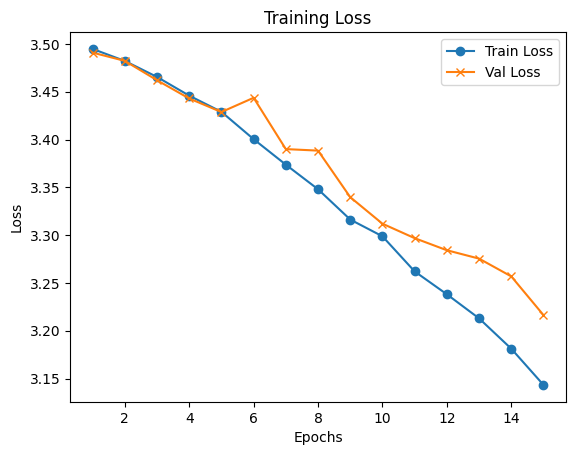

([3.494847188393275,
  3.482274559636911,
  3.465541442235311,
  3.445943287677235,
  3.429034901989831,
  3.400423948135641,
  3.373744777507252,
  3.3480142313573094,
  3.3163099388281503,
  3.298788793385029,
  3.2620570436120033,
  3.2381064742803574,
  3.2129195142123432,
  3.181176055636671,
  3.1432877224352627],
 [3.4909853041172028,
  3.482344220081965,
  3.46211439371109,
  3.4429943793349795,
  3.428808245393965,
  3.4437250594298043,
  3.3900307748052807,
  3.388448135720359,
  3.339737868971295,
  3.311970098151101,
  3.2968521118164062,
  3.2842013041178384,
  3.275436474217309,
  3.256840536991755,
  3.21634194917149])

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 20, patience = 5):
    model.train() #Modeli eğitim moduna alır.
    train_losses = [] # Elde edilen loss değerlerini saklamak için.
    val_loss = [] # Elde edilen validation loss değerini saklamak için.
    early_stopping = EarlyStopping(patience=patience)
    scaler = torch.cuda.amp.GradScaler() #Grands scaler
    
    for epoch in range(epochs): #Belirtilen epoch sayısı kadar eğitim yaptırır.
        model.train() #Modeli eğitim moduna sokar.
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
    
            with torch.cuda.amp.autocast():  # Otomatik mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
    
            scaler.scale(loss).backward()    # Loss’u ölçekle ve backward yapar
            scaler.step(optimizer)           # Optimizer step
            scaler.update()                  # GradScaler günceller
            
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader) #Ortalama kayıp hesaplama.
        train_losses.append(avg_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        
        print(f"epoch: {epoch+1}/{epochs}, Train Loss: {avg_loss:.5f}, Val Loss: {avg_val_loss:.5f}") #Train ve validation lossu yazdırır.

        early_stopping(avg_val_loss) #Overfitting varsa eğitimi durdurur (early stopping).
        if early_stopping.early_stop:
            print("Early stopping tetiklendi!")
            break        
    #loss grafiği çizer.
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, marker='x', label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()
    
    return train_losses, val_loss
    
train_loader, val_loader, test_loader, full_train_set = data_loader()
model = CNN().to(device)
criterion, optimizer = loss_optimizer(model)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs= 15)

Hiperparametre Optimiziasyonu

In [7]:
#def objective(trial):
    # Hyperparametre Aralıkları.
    #lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    #dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
    #batch_size = trial.suggest_categorical('batch_size', [32, 64])  
    #optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])
    #weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Dataloader.
    #train_loader, val_loader, _, full_train_set = data_loader(batch_size=batch_size)

    # Model ve Optimizer.
    #model = CNN(dropout=dropout, num_classes=len(full_train_set.classes)).to(device)

    #if optimizer_name == "Adam":
        #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #elif optimizer_name == "AdamW":
        #optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    #else:
        #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    #criterion = nn.CrossEntropyLoss()

    # Eğitim.
    #train_losses, val_losses = train_model(
        #model, train_loader, val_loader, criterion, optimizer,
        #epochs=10, patience=3
    #)

    # Son validation loss objective olarak dönülüyor.
    #return val_losses[-1]

# Optuna Çalıştırma.
#if __name__ == "__main__":
    #study = optuna.create_study(direction="minimize")
    
    # tqdm ile progress bar.
    #for _ in tqdm(range(20), desc="Hyperparameter Trials"):
        #study.optimize(objective, n_trials=1)

    #print("En iyi parametreler:", study.best_params)
    #print("En iyi validation loss:", study.best_value)

Modelin Performans Değerlendirmesi

epoch: 1/15, Train Loss: 3.49536, Val Loss: 3.48623
epoch: 2/15, Train Loss: 3.47522, Val Loss: 3.46504
epoch: 3/15, Train Loss: 3.44650, Val Loss: 3.45152
epoch: 4/15, Train Loss: 3.42216, Val Loss: 3.42277
epoch: 5/15, Train Loss: 3.38681, Val Loss: 3.37026
epoch: 6/15, Train Loss: 3.34156, Val Loss: 3.34210
epoch: 7/15, Train Loss: 3.30145, Val Loss: 3.29824
epoch: 8/15, Train Loss: 3.24946, Val Loss: 3.27652
epoch: 9/15, Train Loss: 3.21111, Val Loss: 3.22878
epoch: 10/15, Train Loss: 3.15820, Val Loss: 3.20595
epoch: 11/15, Train Loss: 3.11927, Val Loss: 3.16568
epoch: 12/15, Train Loss: 3.07257, Val Loss: 3.14925
epoch: 13/15, Train Loss: 3.03628, Val Loss: 3.11591
epoch: 14/15, Train Loss: 2.98788, Val Loss: 3.09522
epoch: 15/15, Train Loss: 2.95488, Val Loss: 3.08225


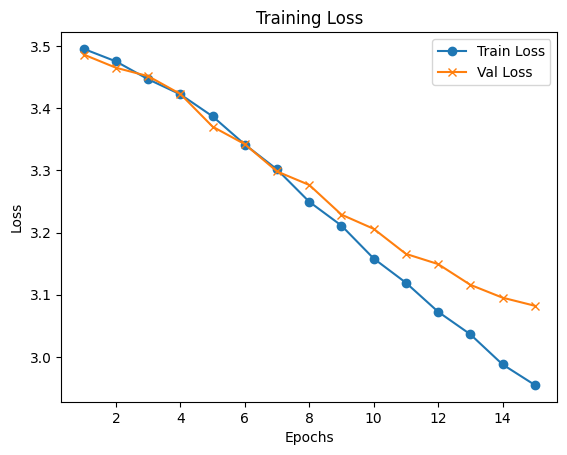

Accuracy : 17.58%


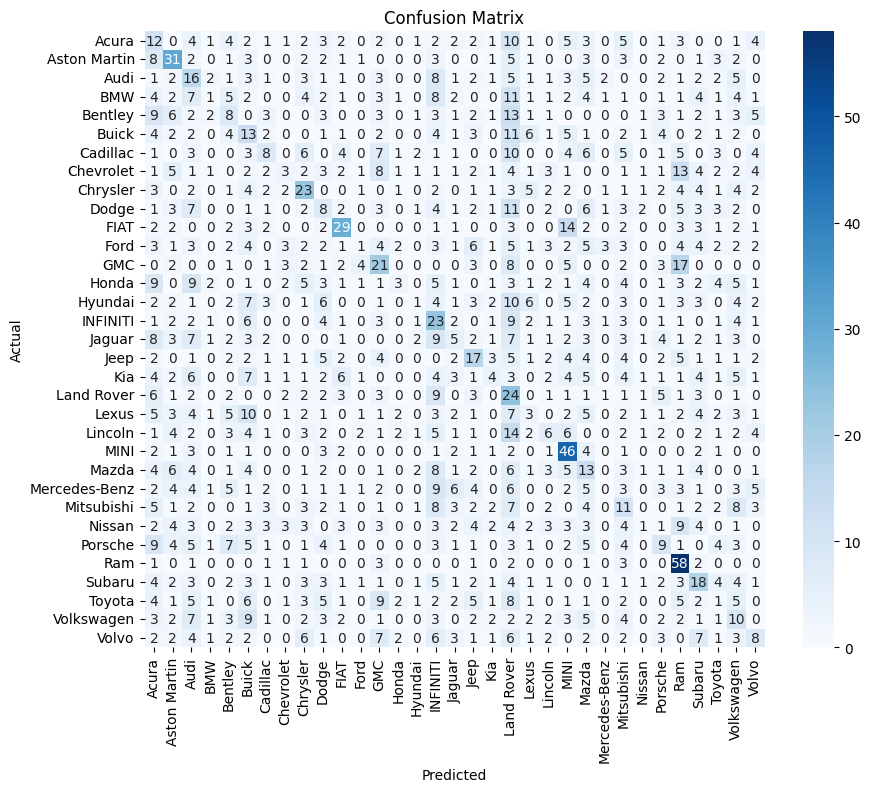

Classification Report :
               precision    recall  f1-score   support

        Acura       0.10      0.16      0.12        75
 Aston Martin       0.31      0.41      0.35        75
         Audi       0.13      0.21      0.16        75
          BMW       0.06      0.01      0.02        75
      Bentley       0.12      0.11      0.11        75
        Buick       0.11      0.17      0.14        75
     Cadillac       0.19      0.11      0.14        75
    Chevrolet       0.12      0.04      0.06        75
     Chrysler       0.26      0.31      0.28        75
        Dodge       0.10      0.11      0.11        75
         FIAT       0.40      0.39      0.39        75
         Ford       0.07      0.01      0.02        75
          GMC       0.21      0.28      0.24        75
        Honda       0.18      0.04      0.07        75
      Hyundai       0.06      0.01      0.02        75
     INFINITI       0.15      0.31      0.20        75
       Jaguar       0.10      0.07      

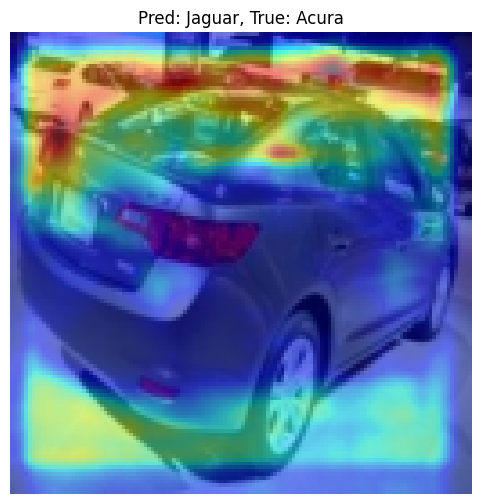

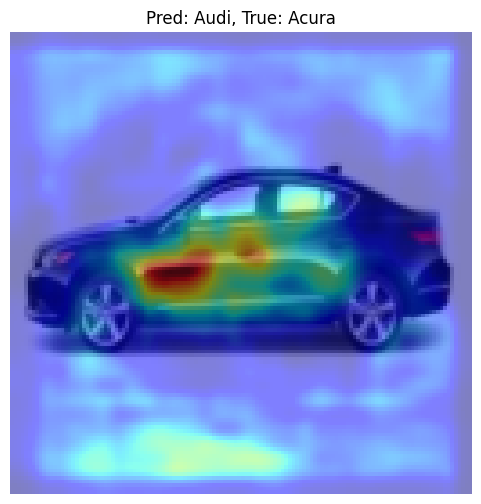

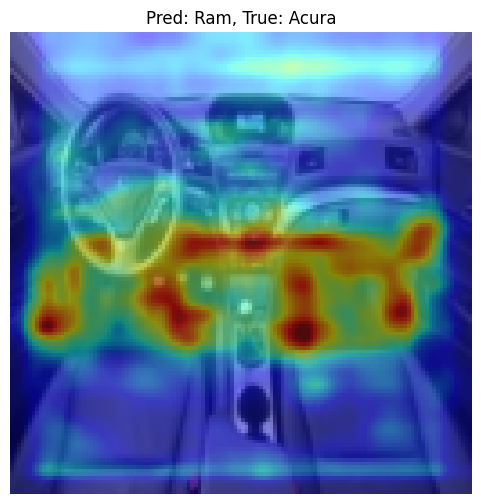

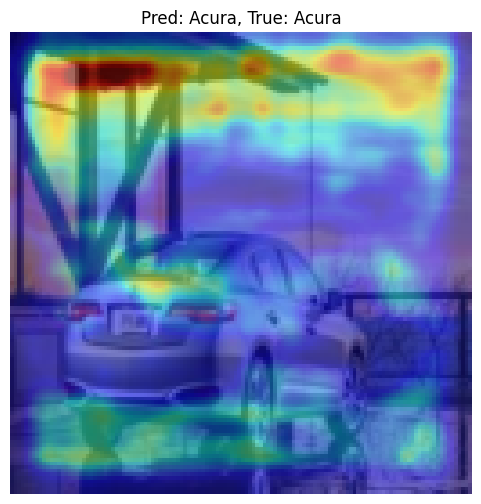

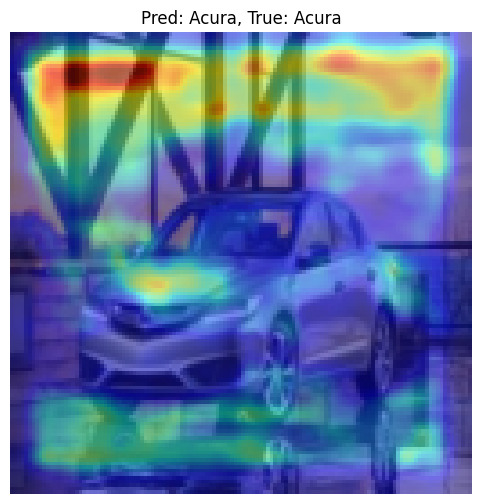

In [10]:
def detailed_test_model(model, test_loader, class_names):
    model.eval()  # Modeli değerlendirme moduna al
    all_preds = []  # Tüm tahminleri depolamak için liste
    all_labels = []  # Tüm gerçek etiketleri depolamak için liste
    
    
    with torch.no_grad():
        for images, labels in test_loader:  # Test veri setindeki her batch için
            images, labels = images.to(device), labels.to(device)  # Verileri GPU ya taşır.
            outputs = model(images)  # Modelden çıktı alır.
            _, preds = torch.max(outputs, 1)  # En yüksek olasılığa sahip sınıfı seçer.
            all_preds.extend(preds.cpu().numpy())  # Tahminleri listeye ekler.
            all_labels.extend(labels.cpu().numpy())  # Gerçek etiketlerilisteye ekler.
    
    # Accuracy hesapla
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Accuracy : {accuracy*100:.2f}%")  # Yüzde formatında yazdır.
    
    # Confusion matrix oluştur
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))  
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted")  
    plt.ylabel("Actual")  
    plt.title("Confusion Matrix") 
    plt.show()  
    
    # Classification report yazdırır.
    print("Classification Report :")
    print(classification_report(all_labels, all_preds, target_names = class_names))


# Grad-CAM görselleştirme fonksiyonu.
def gradcam_visualize(model, loader, class_names, num_images = 5):
    model.eval()  # Modeli değerlendirme moduna alır.
    cam_extractor = GradCAM(model, target_layer = "conv3")  # Son convolution katmanını Grad-CAM için seçer.
    images_shown = 0  # Kaç resim gösterildiğini takip ederr.
    
    for images, labels in loader:  # Test loader’dan batch alır.
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  # Modelden tahmin alır.
        preds = outputs.argmax(dim = 1)  # Tahmin edilen sınıf indeksini alır.
        
        for i in range(len(images)): 
            if images_shown >= num_images:  # İstenen sayıya ulaştıysa bitir.
                return
            
            # Grad-CAM çıktısı al
            activation_map = cam_extractor(preds[i].item(), outputs, retain_graph=True)[0]  # (C,H,W) boyutunda olur
            activation_map = activation_map.mean(dim = 0)  # Kanal boyutunda ortalama alır.
            activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize eder.
            
            # Orijinal resmi geri dönüştürür.
            img = to_pil_image(images[i].cpu() * 0.5 + 0.5)
            
            
            result = overlay_mask(img, to_pil_image(activation_map.cpu(), mode='F'), alpha=0.5)
            heatmap = to_pil_image(activation_map.cpu(), mode='F')
            
            # Görselleştir.
            plt.figure(figsize=(6,6))
            plt.imshow(result)
            plt.title(f"Pred: {class_names[preds[i]]}, True: {class_names[labels[i]]}")
            plt.axis('off')  
            plt.show()
            
            images_shown += 1 


# Çalıştırma kısmı.
train_loader, val_loader, test_loader, full_train_set = data_loader(batch_size = 32)  # Veri yükleyicisi.
model = CNN(num_classes = len(full_train_set.classes)).to(device)  # Modeli oluştur ve GPU ya gönderir.
criterion = nn.CrossEntropyLoss()  # Kayıp fonksiyonu
optimizer = optim.Adam(model.parameters(), lr = 0.0005)  # Adam optimizer.

# Normal eğitim yap.
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 15)

# Detaylı test çalıştır.
detailed_test_model(model, test_loader, full_train_set.classes)

# Grad-CAM görselleştirme çalıştır.
gradcam_visualize(model, test_loader, full_train_set.classes, num_images = 5)


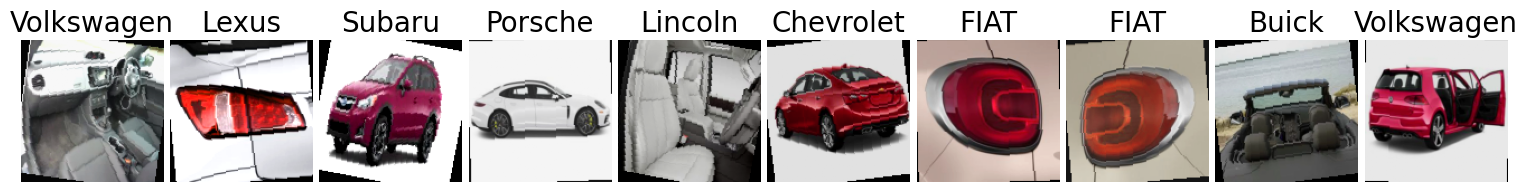

epoch: 1/20, Train Loss: 3.49834, Val Loss: 3.49475
epoch: 2/20, Train Loss: 3.49120, Val Loss: 3.48287
epoch: 3/20, Train Loss: 3.47988, Val Loss: 3.46847


In [ ]:
# Bütün işlemleri bir araya getirip çalıştırır.
if __name__ == "__main__":
    # Veri seti yükleme.
    train_loader, val_loader, test_loader, full_train_set = data_loader()

    # Görselleştirme.
    visualize(10)

    # Training.
    model = CNN(num_classes=len(full_train_set.classes)).to(device)
    criterion, optimizer = loss_optimizer(model)
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

    # Test.
    detailed_test_model(model, test_loader, full_train_set.classes)

    # Grad-CAM görselleştirme.
    gradcam_visualize(model, test_loader, full_train_set.classes, num_images=5)